In [1]:
import os
import glob
from keras_video import VideoFrameGenerator
import numpy as np
import pandas as pd

## Data Loading and Preprocessing

In [2]:
# Use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('Dataset/*')]
classes.sort()

# Some global params
SIZE = (128, 128)    # Image size
CHANNELS = 3         # Color channel
NBFRAME = 30         # Frames per video
BS = 2               # Batch size

# Pattern to get videos and classes
glob_pattern = 'Dataset/{classname}/*.mp4'

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.20,
    split_test=.20, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None, # Data Augmentation
    use_frame_cache=False,
    seed=42)

class Agem_Kanan, validation count: 24, test count: 19, train count: 77
class Agem_Kiri, validation count: 24, test count: 19, train count: 77
class Ngegol, validation count: 24, test count: 19, train count: 77
class Nyalud, validation count: 24, test count: 19, train count: 77
class Nyeregseg, validation count: 24, test count: 19, train count: 77
class Seledet, validation count: 24, test count: 19, train count: 77
class Ulap_Ulap, validation count: 24, test count: 19, train count: 77
Total data: 7 classes for 539 files for train


In [3]:
valid = train.get_validation_generator()
test = train.get_test_generator()

Total data: 7 classes for 168 files for validation
Total data: 7 classes for 133 files for test


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D, LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16

In [5]:
input_shape = (NBFRAME,) + SIZE + (CHANNELS,)

In [6]:
# Define VGG16 model
model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape[1:])
model_vgg16.trainable = False

model = Sequential()

model.add(TimeDistributed(model_vgg16, input_shape=input_shape))
model.add(TimeDistributed(GlobalAveragePooling2D()))

# Define LSTM model
model.add(LSTM(256))

# Dense layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(int(len(classes)), activation='softmax'))

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 4, 4, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               787456    
_________________________________________________________________
dense (Dense)                (None, 1024)              263168    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7175      
Total params: 15,772,487
Trainable params: 1,057,799
Non-

In [7]:
epochs = 100

earlystop = EarlyStopping(monitor='loss', patience=10)
checkpoint = ModelCheckpoint('Checkpoint/vgg16-lstm.h5', monitor='val_acc', save_best_only=True, mode='max', verbose=1)

callbacks = [earlystop, checkpoint]

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [8]:
history = model.fit(train,
                    validation_data=valid,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/100
269/269 [==============================] - 86s 275ms/step - loss: 1.9273 - acc: 0.1653 - val_loss: 1.5761 - val_acc: 0.2857

Epoch 00001: val_acc improved from -inf to 0.28571, saving model to Checkpoint/vgg16-lstm.h5
Epoch 2/100
269/269 [==============================] - 68s 253ms/step - loss: 1.5526 - acc: 0.2877 - val_loss: 1.5472 - val_acc: 0.2857

Epoch 00002: val_acc did not improve from 0.28571
Epoch 3/100
269/269 [==============================] - 68s 252ms/step - loss: 1.5369 - acc: 0.3067 - val_loss: 1.6913 - val_acc: 0.2440

Epoch 00003: val_acc did not improve from 0.28571
Epoch 4/100
269/269 [==============================] - 68s 252ms/step - loss: 1.5375 - acc: 0.3142 - val_loss: 1.5901 - val_acc: 0.2857

Epoch 00004: val_acc did not improve from 0.28571
Epoch 5/100
269/269 [==============================] - 68s 252ms/step - loss: 1.4572 - acc: 0.3852 - val_loss: 1.3509 - val_acc: 0.3929

Epoch 00005: val_acc improved from 0.28571 to 0.39286, saving model to C


Epoch 00083: val_acc improved from 0.83929 to 0.86310, saving model to Checkpoint/vgg16-lstm.h5
Epoch 84/100
269/269 [==============================] - 67s 250ms/step - loss: 0.0493 - acc: 0.9831 - val_loss: 1.0522 - val_acc: 0.7857

Epoch 00084: val_acc did not improve from 0.86310
Epoch 85/100
269/269 [==============================] - 67s 250ms/step - loss: 0.2997 - acc: 0.9169 - val_loss: 0.6840 - val_acc: 0.8393

Epoch 00085: val_acc did not improve from 0.86310
Epoch 86/100
269/269 [==============================] - 67s 250ms/step - loss: 0.0631 - acc: 0.9755 - val_loss: 0.8256 - val_acc: 0.8274

Epoch 00086: val_acc did not improve from 0.86310


In [9]:
model.save('Model/tari/vgg16-lstm-86e-0.82.h5')

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

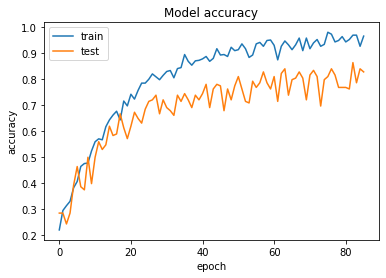

In [11]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

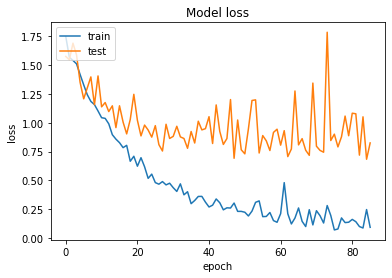

In [12]:
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Save history to csv
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history_vgg16_lstm.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Testing

In [14]:
model.evaluate(test)

66/66 [==============================] - 14s 208ms/step - loss: 1.3495 - acc: 0.7348


[1.3495113849639893, 0.7348484992980957]

In [15]:
y_test = []
y_predict = []
for step in range(test.files_count//BS):
    X, y = test.next()
    prediction = model.predict(X)
    y_test.extend(y)
    y_predict.extend(prediction)

In [16]:
y_true = np.argmax(y_test, axis=1)
prediction = np.argmax(y_predict, axis=1)

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, \
roc_curve, auc

In [18]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, prediction)
print(f'Accuracy: {np.round(accuracy, 3)}')
# precision tp / (tp + fp)
precision = precision_score(y_true, prediction, average='macro')
print(f'Precision: {np.round(precision, 3)}')
# recall: tp / (tp + fn)
recall = recall_score(y_true, prediction, average='macro')
print(f'Recall: {np.round(recall, 3)}')
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, prediction, average='macro')
print(f'F1 score: {np.round(f1, 3)}')

Accuracy: 0.742
Precision: 0.766
Recall: 0.742
F1 score: 0.745


## Discussion

In [19]:
target_names = test.classes
print(classification_report(y_true, prediction, target_names=target_names))

              precision    recall  f1-score   support

  Agem_Kanan       0.92      0.58      0.71        19
   Agem_Kiri       0.76      0.72      0.74        18
      Ngegol       0.67      0.84      0.74        19
      Nyalud       0.56      0.53      0.54        19
   Nyeregseg       0.94      0.84      0.89        19
     Seledet       1.00      1.00      1.00        19
   Ulap_Ulap       0.52      0.68      0.59        19

    accuracy                           0.74       132
   macro avg       0.77      0.74      0.75       132
weighted avg       0.77      0.74      0.75       132



<AxesSubplot:>

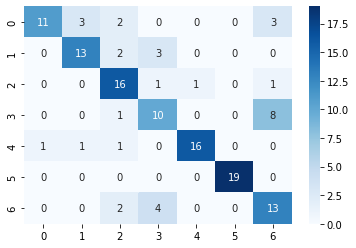

In [20]:
matrix = confusion_matrix(y_true, prediction)
sns.heatmap(matrix, annot=True, cmap='Blues')

In [21]:
fpr, tpr, _ = roc_curve(y_true, prediction, pos_label=6)
auc_score = auc(fpr, tpr)
print(f'AUC Score : {np.round(auc_score, 3)}')

AUC Score : 0.793


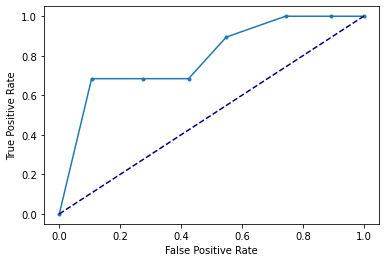

In [22]:
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Model from checkpoint

In [23]:
from tensorflow.keras.models import load_model

In [24]:
ckp_model = load_model('Checkpoint/vgg16-lstm.h5')

In [25]:
ckp_model.evaluate(test)

66/66 [==============================] - 13s 194ms/step - loss: 1.0025 - acc: 0.7803


[1.0024648904800415, 0.7803030014038086]

In [26]:
y_test = []
y_predict = []
for step in range(test.files_count//BS):
    X, y = test.next()
    prediction = ckp_model.predict(X)
    y_test.extend(y)
    y_predict.extend(prediction)

In [27]:
y_true = np.argmax(y_test, axis=1)
prediction = np.argmax(y_predict, axis=1)

In [28]:
target_names = test.classes
print(classification_report(y_true, prediction, target_names=target_names))

              precision    recall  f1-score   support

  Agem_Kanan       1.00      0.63      0.77        19
   Agem_Kiri       0.78      0.74      0.76        19
      Ngegol       0.75      0.79      0.77        19
      Nyalud       0.61      0.61      0.61        18
   Nyeregseg       0.82      0.95      0.88        19
     Seledet       1.00      1.00      1.00        19
   Ulap_Ulap       0.61      0.74      0.67        19

    accuracy                           0.78       132
   macro avg       0.80      0.78      0.78       132
weighted avg       0.80      0.78      0.78       132



<AxesSubplot:>

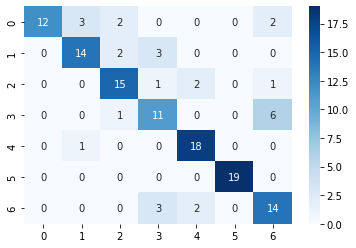

In [29]:
matrix = confusion_matrix(y_true, prediction)
sns.heatmap(matrix, annot=True, cmap='Blues')

In [30]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, prediction)
print(f'Accuracy: {np.round(accuracy, 3)}')
# precision tp / (tp + fp)
precision = precision_score(y_true, prediction, average='macro')
print(f'Precision: {np.round(precision, 3)}')
# recall: tp / (tp + fn)
recall = recall_score(y_true, prediction, average='macro')
print(f'Recall: {np.round(recall, 3)}')
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, prediction, average='macro')
print(f'F1 score: {np.round(f1, 3)}')

Accuracy: 0.78
Precision: 0.795
Recall: 0.779
F1 score: 0.779


In [31]:
fpr, tpr, _ = roc_curve(y_true, prediction, pos_label=6)
auc_score = auc(fpr, tpr)
print(f'AUC Score : {np.round(auc_score, 3)}')

AUC Score : 0.858


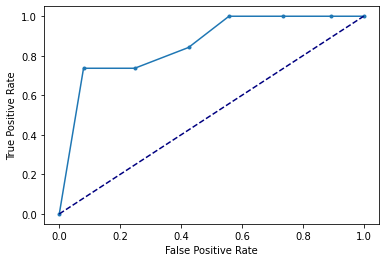

In [32]:
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()